# 3D Image Segmentation with a 2D UNET

# 1) Imports and mount

In [7]:
# Notebook Setups
%load_ext autoreload
%autoreload 2

import os

# make root project the cwd
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(format=' %(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()
logger.setLevel(logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import os, glob
from os import path

import nibabel as nib
import numpy as np
import cv2
import os.path
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

# 2) Helper Functions and Global Variables

In [9]:
from src.enums import DataDict, CountryDirType
from src.visualization.visualize import view_slice

## 3.1) Sample Data

Get slices and save into a list dicts

In [10]:
from src.enums import INTERIM_TRAINING_DATA_PATHS, INTERIM_TESTING_DATA_PATHS
from src.utils import get_interim_data_path

interim_train_paths = get_interim_data_path(INTERIM_TRAINING_DATA_PATHS)
interim_test_paths = get_interim_data_path(INTERIM_TESTING_DATA_PATHS)

## 3.3) Transforms

In [11]:
SEED = 2
BATCH_SIZE_TRAIN = 128
BATCH_SIZE_VAL = 64

## 3.5) Dataset and Dataloader

In [13]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [14]:

from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.inferers import SlidingWindowInferer

from monai.data import Dataset, DataLoader
from src.enums import INTERIM_TRAINING_DATA_PATHS
from src.features.build_features import train_transform, val_transform, test_transform

train_paths = get_interim_data_path(INTERIM_TRAINING_DATA_PATHS)
val_paths = get_interim_data_path(INTERIM_TESTING_DATA_PATHS)

train_dataset  = Dataset(train_paths, train_transform)
validation_dataset  = Dataset(val_paths, val_transform)
test_dataset = Dataset(val_paths, test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE_VAL, shuffle=True)

 2023-01-09 19:17:20,841 - INFO - NumExpr defaulting to 8 threads.
c:\Users\zifen\anaconda3\lib\site-packages\monai\utils\deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


In [15]:
train_dataset

15


c:\Users\zifen\anaconda3\lib\site-packages\monai\transforms\spatial\array.py:571: UserWarning: `data_array` is not of type MetaTensor, assuming affine to be identity.
  warnings.warn("`data_array` is not of type MetaTensor, assuming affine to be identity.")
c:\Users\zifen\anaconda3\lib\site-packages\monai\transforms\spatial\array.py:704: UserWarning: axcodes ('RAS') length is smaller than the number of input spatial dimensions D=2.
Orientation: input spatial shape is torch.Size([256, 256]), num. channels is 1,please make sure the input is in the channel-first format.
  warnings.warn(
c:\Users\zifen\anaconda3\lib\site-packages\monai\transforms\spatial\array.py:704: UserWarning: axcodes ('RAS') length is smaller than the number of input spatial dimensions D=2.
Orientation: input spatial shape is torch.Size([256, 256]), num. channels is 2,please make sure the input is in the channel-first format.
  warnings.warn(


tensor([[[0.0729, 0.0729, 0.0729,  ..., 0.0726, 0.0726, 0.0726],
         [0.0729, 0.0729, 0.0729,  ..., 0.0726, 0.0726, 0.0726],
         [0.0729, 0.0729, 0.0729,  ..., 0.0726, 0.0726, 0.0726],
         ...,
         [0.0745, 0.0745, 0.0745,  ..., 0.0738, 0.0738, 0.0738],
         [0.0745, 0.0745, 0.0745,  ..., 0.0738, 0.0738, 0.0738],
         [0.0745, 0.0745, 0.0745,  ..., 0.0738, 0.0738, 0.0738]]])

Shapes: Image torch.Size([2, 256, 256]) 	Flair torch.Size([1, 256, 256])	T1 torch.Size([1, 256, 256])	Label torch.Size([2, 256, 256])
tensor(0.0726)
tensor(0.5529)


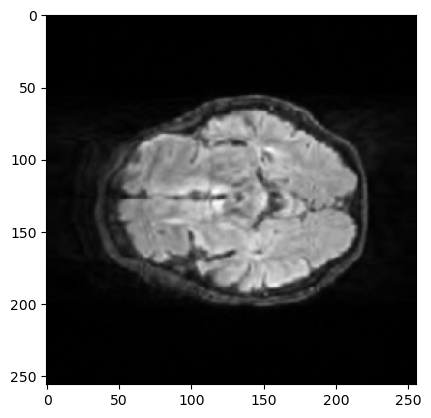

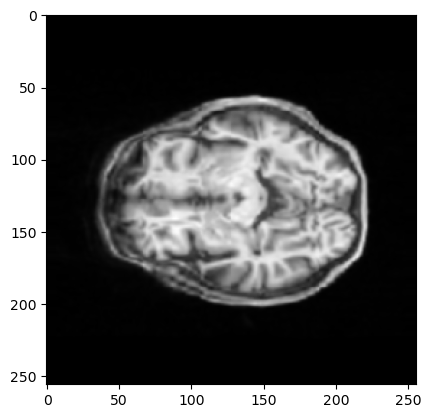

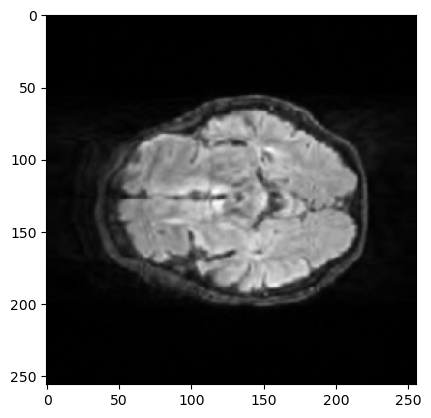

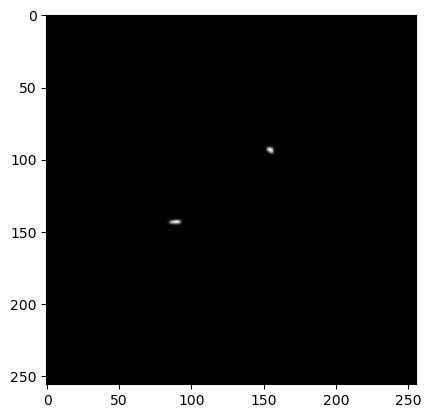

In [16]:
import matplotlib.pyplot as plt

print(len(train_loader))

sample_data = train_dataset.__getitem__(20)
sample_tensor_image, sample_tensor_flair, sample_tensor_t1, sample_tensor_label = sample_data[DataDict.Image], sample_data[DataDict.ImageFlair], sample_data[DataDict.ImageT1], sample_data[DataDict.Label]

print(f'{sample_tensor_flair}\n')
print(f'Shapes: Image {sample_tensor_image.shape} \tFlair {sample_tensor_flair.shape}\tT1 {sample_tensor_t1.shape}\tLabel {sample_tensor_label.shape}')

print(torch.min(sample_tensor_t1))
print(torch.max(sample_tensor_t1))

plt.imshow(sample_tensor_flair.squeeze().detach().cpu() , cmap='gray')
plt.show()
plt.imshow(sample_tensor_image[0].squeeze().detach().cpu() , cmap='gray')
plt.show()
plt.imshow(sample_tensor_image[1].squeeze().detach().cpu() , cmap='gray')
plt.show()
plt.imshow(sample_tensor_label[1].squeeze().detach().cpu() , cmap='gray')
plt.show()

In [ ]:
data_paths = image_dict
unique_subj_id = list(set(list(v[DataDict.Id] for v in data_paths)))

validation_split = 0.2
shuffle_dataset = True

dataset_size_subj = len(unique_subj_id)
# indices = list(range(dataset_size_subj))
split = int(np.floor(validation_split * dataset_size_subj))

print(unique_subj_id)
if shuffle_dataset :
    np.random.seed(SEED)
    np.random.shuffle(unique_subj_id)

train_subjs, val_subjs = unique_subj_id[split:], unique_subj_id[:split]
train_paths, val_paths = get_dicts_from_dicts(data_paths, DataDict.Id, train_subjs), get_dicts_from_dicts(data_paths, DataDict.Id, val_subjs)

train_dataset  = Dataset(train_paths, train_transform)
validation_dataset  = Dataset(val_paths, val_transform)
test_dataset = Dataset(val_paths, test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE_VAL, shuffle=True)

print(unique_subj_id)
print(train_subjs)
print(val_subjs)

In [ ]:
print(len(train_loader))
print(len(validation_loader))

sample_data = train_dataset.__getitem__(20)
sample_tensor_image, sample_tensor_flair, sample_tensor_t1, sample_tensor_label = sample_data[DataDict.Image], sample_data[DataDict.ImageFlair], sample_data[DataDict.ImageT1], sample_data[DataDict.Label]

print(f'{sample_tensor_flair}\n')
print(f'Shapes: Image {sample_tensor_image.shape} \tFlair {sample_tensor_flair.shape}\tT1 {sample_tensor_t1.shape}\tLabel {sample_tensor_label.shape}')

print(torch.min(sample_tensor_t1))
print(torch.max(sample_tensor_t1))

plt.imshow(sample_tensor_flair.squeeze().detach().cpu() , cmap='gray')
plt.show()
plt.imshow(sample_tensor_image[0].squeeze().detach().cpu() , cmap='gray')
plt.show()
plt.imshow(sample_tensor_image[1].squeeze().detach().cpu() , cmap='gray')
plt.show()
plt.imshow(sample_tensor_label[1].squeeze().detach().cpu() , cmap='gray')
plt.show()

In [ ]:
sample_data_2 = train_dataset.__getitem__(320)
sample_tensor_image2, sample_tensor_flair2, sample_tensor_t12, sample_tensor_label2 = sample_data_2[DataDict.Image], sample_data_2[DataDict.ImageFlair], sample_data_2[DataDict.ImageT1], sample_data_2[DataDict.Label]

print(f'{sample_tensor_flair}\n')
print(f'Shapes: Image {sample_tensor_image2.shape} \tFlair {sample_tensor_flair2.shape}\tT1 {sample_tensor_t12.shape}\tLabel {sample_tensor_label2.shape}')
plt.imshow(sample_tensor_flair2.squeeze().detach().cpu() , cmap='gray')
plt.show()
plt.imshow(sample_tensor_image2[0].squeeze().detach().cpu() , cmap='gray')
plt.show()
plt.imshow(sample_tensor_image2[1].squeeze().detach().cpu() , cmap='gray')
plt.show()

# 4) Network

## 4.1) Train Network

In [ ]:
def train_network(training_loader, val_loader, network, loss_fun, optimizer, EPOCHS=200, pre_load_training=False, checkpoint_name=''):
    network.cuda(device)
 
    optimizer = optimizer
    loss_fun = loss_fun 

    epoch_checkpoint = 0

    losses = {}
    val_losses = {}
    
    # Test Learning rate dictionary for visualization
    scheduler_learning_rate_dict = {}

    if pre_load_training:
        checkpoint = torch.load(ROOT_DIR + f'{checkpoint_name}.pt')
        epoch_checkpoint = checkpoint['epoch'] + 1
        network.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        loss = checkpoint['loss']
        losses = checkpoint['losses']
        val_losses = checkpoint['val_losses']
        # learning_rate = checkpoint['learning_rate'] if 'learning_rate' in checkpoint.keys() else optimizer.param_groups[0]["lr"]
    
    # if epoch_checkpoint > 300:
    #     print(f'Learning rate changed from {optimizer.param_groups[0]["lr"]} to:')
    #     optimizer.param_groups[0]["lr"] = 0.0001
    #     print(f'{optimizer.param_groups[0]["lr"]}')

    # Train the network
    for epoch in range(epoch_checkpoint, EPOCHS):
        network.train(True)

        print(f'losses: {losses}')
        print(f'val losses {val_losses}')
        
        train_step = 1
        batch_loss = []

        for batch_data in training_loader:
            print(f'Epoch {epoch}\tTraining Step: {train_step}/{len(training_loader)}')

            torch.cuda.empty_cache() # Clear any unused variables
            inputs = batch_data["image"].to(device)
            labels = batch_data["label"] # Only pass to CUDA when required - preserve memory
            
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Feed input data into the network to train
            outputs = network(inputs)
            
            # Input no longer in use for current iteration - clear from CUDA memory
            inputs = inputs.cpu()
            torch.cuda.empty_cache()
            
            # labels to CUDA
            labels = batch_data["label"].to(device)
            torch.cuda.empty_cache()

            # Calculate DICE CE loss, permute tensors to correct dimensions
            loss = loss_fun(outputs, labels)

            # List of losses for current batch
            batch_loss.append(loss.detach().cpu().numpy())
            
            # Clear CUDA memory
            labels = labels.cpu()
            torch.cuda.empty_cache()
            
            # Backward pass
            loss.backward()
            
            # Optimize
            optimizer.step()

            train_step += 1

        # Get average loss for current batch
        losses[epoch] = np.mean(batch_loss)
        print(f'train losses {batch_loss} \nmean loss {losses[epoch]}')
        
        if epoch % 2 == 0:
            # Set network to eval mode
            network.train(False)
            # Disiable gradient calculation and optimise memory 
            with torch.no_grad():
                # Initialise validation loss
                dice_test_loss = 0
                val_iter_count = 0
                # dice_test_loss = []
                for i, batch_data in enumerate(val_loader):
                    # Get inputs and labels from validation set
                    inputs = batch_data["image"].to(device)
                    labels = batch_data["label"]

                    outputs = network(inputs)

                    # Memory optimization
                    inputs = inputs.cpu()
                    torch.cuda.empty_cache()
                    labels = batch_data["label"].to(device)

                    # Accumulate DICE CE loss validation error
                    test_loss = loss_fun(outputs, labels)
                    dice_test_loss += test_loss
                    # dice_test_loss += loss_fun(outputs, labels)
                    val_iter_count += 1
                    print(f'Val loss iter {i}: {test_loss}')

                # Get average validation DICE CE loss
                val_losses[epoch] = dice_test_loss / val_iter_count
              
                # Print errors 
                print(
                    "==== Epoch: " + str(epoch) + 
                    " | DICE loss: " + str(numpy_from_tensor((dice_test_loss) / val_iter_count)) +
                    " | Total Loss: " + str(numpy_from_tensor((dice_test_loss) / val_iter_count))+ " =====") # This is redundant code but will keep here incase we add more losses
                
                # View slice at halfway point
                half = outputs.shape[2] // 2
                
                # Show predictions for current iteration
                print(f'shape is {inputs.shape}')
                view_slice(numpy_from_tensor(inputs[0, 0, :, :]), f'Input Channel 0 Image Epoch {epoch}', gray=True)
                view_slice(numpy_from_tensor(inputs[0, 1, :, :]), f'Input Channel 1 Image Epoch {epoch}', gray=True)
                view_slice(numpy_from_tensor(outputs[0, 1, :, :]), f'WMH Output Image Epoch {epoch}', gray=True)
                view_slice(numpy_from_tensor(labels[0, 1, :, :]), f'WMH Labels  Epoch {epoch}', gray=True)
        
        # Save training checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'losses': losses,
            'val_losses': val_losses,
            # 'learning_rate': optimizer.param_groups[0]['lr']
            # 'scheduler_learning_rate_dict':scheduler_learning_rate_dict
        }, ROOT_DIR + f'{checkpoint_name}.pt')

        # Confirm current epoch trained params are saved 
        print(f'Saved for epoch {epoch}')

    return network

## 4.2) Initialise network params

In [ ]:
class UNet(UNet):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = super().forward(x)
        x = F.softmax(x)
        return x

In [ ]:
device = torch.device("cuda")
model = UNet(
    dimensions=2,
    in_channels=2,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    dropout=0.2,
    # kernel_size=3,
).to(device)

loss_function = DiceLoss()

optimizer = torch.optim.Adam(
    model.parameters(), 1e-3, weight_decay=1e-5, amsgrad=True, 
)

from torchvision import models
from torchsummary import summary

summary(model, (2, 256, 256))

## 4.3) Train data

In [ ]:
net = train_network(training_loader=train_loader, val_loader=validation_loader, network=model, 
                    loss_fun=loss_function, optimizer=optimizer, EPOCHS=2000, pre_load_training=True, checkpoint_name='unet_brain_wmi_UbSi_new_norm')

# 5) Test network

In [ ]:
# Load the network for testing
pred_network = model

checkpoint = torch.load(ROOT_DIR + '/unet_brain_wmi_UbSi_new_norm.pt')
epoch_checkpoint = checkpoint['epoch']
losses = checkpoint['losses']
val_losses = checkpoint['val_losses']
pred_network.load_state_dict(checkpoint['model_state_dict'])

# print(checkpoint['model_state_dict'])
print(epoch_checkpoint)
print(losses)
print(val_losses)



In [ ]:

print(losses)
print(val_losses)


# Plot the validation and training losses
print(val_losses)
val_tensors = dict_tensor_to_value(val_losses)
print(val_tensors)

training_losses = sorted(losses.items()) # sorted by key, return a list of tuples
x, y = zip(*training_losses) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

validation_losses = sorted(val_tensors.items())
x2, y2 = zip(*validation_losses) # unpack a list of pairs into two tuples

plt.plot(x2, y2)
plt.title('Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(x, y, label = "Training")
plt.plot(x2, y2, label = "Validation")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from torchvision import models
from torchsummary import summary

summary(pred_network, (2, 256, 256))

# 6) Test Whole Volume

In [ ]:
class ImagePredictor():
    def __init__(self, model, dataset):
        self.model = model
        # Passed as 2D slices with information about depth for reconstruction
        self.dataset = dataset

    def predict(self):
        self.slice_predictions = []
        with torch.no_grad():
            self.model.eval()
            pred_count = 1

            for data in self.dataset:
                if pred_count == 1 or pred_count % 50 == 0 or pred_count == len(self.dataset):
                    print(f'Predicting {pred_count}/{len(self.dataset)} slices')
                image = data[DataDict.Image]
                label = data[DataDict.Label]
                subj_id = data[DataDict.Id]
                depth_z = data[DataDict.DepthZ]

                image = image.unsqueeze(dim=0)
                image = image.to(device)

                output = one_hot(self.model(image))

                self.slice_predictions.append({
                    DataDict.Id: subj_id,
                    DataDict.DepthZ: depth_z,
                    DataDict.Label: label,
                    DataDict.Prediction: output
                })

                # print(self.slice_predictions)

                pred_count += 1
                

    def predict_handler(self):
        # Predict all slices
        self.predict()
        self.volume_predictions = []

        subj_ids = list(set(list(v[DataDict.Id] for v in self.slice_predictions)))

        print(f'{len(subj_ids)} subjects to predict')
        pred_count = 1
        # For all subjects
        for subject_id in subj_ids:
            print(f'Reconstructing {pred_count}/{len(subj_ids)}')
            # Find all slice_predictions by subjects
            subject_predictions = get_dicts_from_dicts(self.slice_predictions, DataDict.Id, [subject_id])
          
            # Reconstruct volume by subject
            volume_prediction, volume_label = self.reconstruct(subject_predictions)
        
            self.volume_predictions.append({
                DataDict.Id: subject_id,
                DataDict.Prediction: volume_prediction,
                DataDict.Label: volume_label
            })

            pred_count += 1

        return self.volume_predictions

    def reconstruct(self, subj_predictions):
        # sorted_subbj_pred_by_depth = sorted(subj_predictions, key=itemgetter(DataDict.DepthZ))     
        z_length = len(subj_predictions)  
        prediction_volume = torch.zeros((256, 256, z_length))
        label_volume = torch.zeros((256, 256, z_length))
        subj_id = subj_predictions[0][DataDict.Id]

        for i in range(z_length):
            # only take second channel
            if subj_predictions[i][DataDict.DepthZ] != i:
                raise ValueError("Reconstruction error: Slice missing") 

            subj_slice = subj_predictions[i] 
            # print(f'slice prediction {subj_slice[DataDict.Prediction].shape}')
            # print(f'slice label {subj_slice[DataDict.Label].shape}')
            prediction_volume[..., i] = subj_slice[DataDict.Prediction][0, 1, ...]
            label_volume[..., i] = subj_slice[DataDict.Label][1]

        return prediction_volume, label_volume

In [ ]:
# test_datasaet
img_predictor = ImagePredictor(pred_network, test_dataset)
test_predictions = img_predictor.predict_handler()
print('DONE')

In [ ]:
len(test_predictions)

In [ ]:
from monai.metrics import compute_meandice, DiceMetric

dice_scores = []

for i in range(len(test_predictions)):
    test_subject_prediction = test_predictions[i]

    print(test_subject_prediction[DataDict.Label].shape)
    print(test_subject_prediction[DataDict.Prediction].shape)

    pred = test_subject_prediction[DataDict.Prediction]
    label = test_subject_prediction[DataDict.Label]

    print(torch.max(pred))
    print(torch.min(pred))

    dice_metric = DiceLoss()
    # print(compute_meandice(pred, label))
    dice_score = 1 - dice_metric(pred, label)

    dice_scores.append(dice_score.item())


In [ ]:
dice_scores


In [ ]:
from numpy import mean
mean_dice_score = round(mean(dice_scores), 5) 
mean_dice_score

In [ ]:
# view_slice(numpy_from_tensor(inputs[0, 0, :, :]), f'Input Channel 0 Image Epoch {epoch}', gray=True)
# view_slice(numpy_from_tensor(inputs[0, 1, :, :]), f'Input Channel 1 Image Epoch {epoch}', gray=True)
# view_slice(numpy_from_tensor(outputs[0, 1, :, :]), f'WMH Output Image Epoch {epoch}', gray=True)
# view_slice(numpy_from_tensor(pred[..., 25]), f'WMH Pred', gray=True)
# view_slice(numpy_from_tensor(label[..., 25]), f'WMH Labels', gray=True)

w = 200
h = 200
fig = plt.figure(figsize=(200, 600))
fig.set_figheight(h)
fig.set_figwidth(w)
columns = 8
rows = 12

label_count = 0
pred_count = 0
row = 1

for i in range(1, columns * rows + 1):  
    fig.add_subplot(rows, columns, i)
    # Prediction row
    if row % 2 != 0:
        plt.subplot(rows, columns, i).set_title(f'Prediction Depth {pred_count}', fontweight="bold", size=80)
        plt.imshow(pred[..., pred_count], cmap='gray')
        pred_count += 1
    # Label row
    else:
        plt.subplot(rows, columns, i).set_title(f'Label Depth {label_count}', fontweight="bold", size=80)
        plt.imshow(label[..., label_count], cmap='gray')
        label_count += 1

    
    row += 1 if i % 8 == 0 else 0
plt.show()